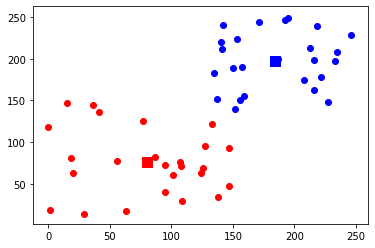

In [1]:
import numpy as np, cv2
import matplotlib.pyplot as plt

# 0~150 임의의 2수, 25개 ---①
a = np.random.randint(0,150,(25,2))
# 128~255 임의의 2수, 25개  ---②
b = np.random.randint(128, 255,(25,2))
# a, b를 병합 ---③
data = np.vstack((a,b)).astype(np.float32)
# 중지 요건 ---④
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# 평균 클러스터링 적용 ---⑤
ret,label,center=cv2.kmeans(data,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# label에 따라 결과 분류 ---⑥
red = data[label.ravel()==0]
blue = data[label.ravel()==1]

# plot에 결과 출력 ---⑦
plt.scatter(red[:,0],red[:,1], c='r')
plt.scatter(blue[:,0],blue[:,1], c='b')
# 각 그룹의 중앙점 출력 ---⑧
plt.scatter(center[0,0],center[0,1], s=100, c='r', marker='s')
plt.scatter(center[1,0],center[1,1], s=100, c='b', marker='s')
plt.show()

In [1]:
import numpy as np
import cv2

K = 16 # 군집화 갯수(16컬러) ---①
img = cv2.imread('./img/taekwonv1.jpg')
# 군집화를 위한 데이타 구조와 형식 변환 ---②
data = img.reshape((-1,3)).astype(np.float32)
# 반복 중지 요건 ---③
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# 평균 클러스터링 적용 ---④
ret,label,center=cv2.kmeans(data,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# 중심 값을 정수형으로 변환 ---⑤
center = np.uint8(center)
print(center)
# 각 레이블에 해당하는 중심값으로 픽셀 값 선택 ---⑥
res = center[label.flatten()]
# 원본 영상의 형태로 변환 ---⑦
res = res.reshape((img.shape))
# 결과 출력 ---⑧
merged = np.hstack((img, res))
cv2.imshow('KMeans Color',merged)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[  9 139 179]
 [ 10 106 134]
 [ 74  76 184]
 [126  71  29]
 [155 152 143]
 [171  99  27]
 [142 118  75]
 [ 55  23   8]
 [189 191 190]
 [ 75  61  53]
 [204 142  63]
 [ 19  17 149]
 [ 99  48  17]
 [209 212 213]
 [ 90 109 101]
 [ 42 181 200]]


In [1]:
import numpy as np, cv2

data = None  # 이미지 데이타 셋 
k = list(range(10)) # [0,1,2,3,4,5,6,7,8,9] 레이블 셋

# 이미지 데이타 읽어들이는 함수 ---①
def load():
    global data
    # 0~9 각각 500(5x100)개, 총5000(50x100)개, 한 숫자당 400(20x20)픽셀
    image = cv2.imread('./img/digits.png')
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # 숫자 한개(20x20)씩 구분하기 위해 행별(50)로 나누고 열별(100)로 나누기
    cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]
    # 리스트를 NumPy 배열로  변환 (50 x 100 x 20 x 20 )
    data = np.array(cells)

# 모든 숫자 데이타 반환 ---②
def getData(reshape=True):
    if data is None: load() # 이미지 읽기 확인
    # 모든 데이타를 N x 400 형태로 변환
    if reshape:
        full = data.reshape(-1, 400).astype(np.float32) # 5000x400
    else:
        full = data
    labels = np.repeat(k,500).reshape(-1,1)  # 각 숫자당 500번 반복(10x500)
    return (full, labels)

# 훈련용 데이타 반환 ---③
def getTrain(reshape=True):
    if data is None: load() # 이미지 읽기 확인
    # 50x100 중에 90열만 훈련 데이타로 사용
    train = data[:,:90]
    if reshape:
        # 훈련 데이타를 N X 400으로 변환
        train = train.reshape(-1,400).astype(np.float32) # 4500x400
    # 레이블 생성
    train_labels = np.repeat(k,450).reshape(-1,1) # 각 숫자당 45번 반복(10x450)
    return (train, train_labels)

# 테스트용 데이타 반환 ---④
def getTest(reshape=True):
    if data is None: load()
    # 50x100 중에 마지막 10열만 훈련 데이타로 사용
    test = data[:,90:100]
    # 테스트 데이타를 N x 400으로 변환
    if reshape:
        test = test.reshape(-1,400).astype(np.float32) # 500x400
    test_labels = np.repeat(k,50).reshape(-1,1)
    return (test, test_labels)


# 손글씨 숫자 한 개를 20x20 로 변환후에 1x400 형태로 변환 ---⑤
def digit2data(src, reshape=True):
    h, w = src.shape[:2]
    square = src
    # 정사각형 형태로 만들기
    if h > w:
        pad = (h - w)//2
        square = np.zeros((h, h), dtype=np.uint8)
        square[:, pad:pad+w] = src
    elif w > h :
        pad = (w - h)//2
        square = np.zeros((w, w), dtype=np.uint8)
        square[pad:pad+h, :] = src
    # 0으로 채워진 20x20 이미지 생성
    px20 = np.zeros((20,20), np.uint8)
    # 원본을 16x16으로 축소해서 테두리 2픽셀 확보
    px20[2:18, 2:18] = cv2.resize(square, (16,16), interpolation=cv2.INTER_AREA)
    if reshape:
        # 1x400형태로 변환
        px20 = px20.reshape((1,400)).astype(np.float32)
    return px20


In [4]:
import cv2, numpy as np
import matplotlib.pyplot as plt
import mnist

# 공통 모듈로 부터 MINST 전체 이미지 데이타 읽기 ---①
data, _ = mnist.getData()
# 중지 요건 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# 평균 클러스터링 적용, 10개의 그룹으로 묶음 ---②
ret,label,center=cv2.kmeans(data,10,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# 중앙점 이미지 출력
for i in range(10):
    # 각 중앙점 값으로 이미지 생성 ---③
    cent_img = center[i].reshape(20,20).astype(np.uint8)
    plt.subplot(2,5, i+1)
    plt.imshow(cent_img, 'gray')
    plt.xticks([]);plt.yticks([])
plt.show()

error: OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


ret:1.0, result:[[1.]], negibours:[[1. 1. 1.]], distance:[[ 160. 1125. 1746.]]


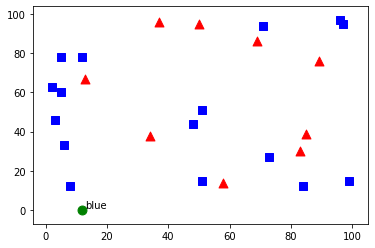

In [5]:
import cv2,  numpy as np,  matplotlib.pyplot as plt

# 0~99 사이의 랜덤한 수 25x2개 데이타 생성 ---①
trainData = np.random.randint(0,100,(25,2)).astype(np.float32)
# 0~1 사이의 랜덤 수 25x1개 레이블 생성 ---②
labels = np.random.randint(0,2,(25,1))
# 레이블 값 0과 같은 자리는 red, 1과 같은 자리는 blue로 분류해서 표시
red = trainData[labels.ravel()==0]
blue = trainData[labels.ravel()==1]
plt.scatter(red[:,0], red[:,1], 80, 'r', '^') # 빨강색 삼각형
plt.scatter(blue[:,0], blue[:,1], 80, 'b', 's')# 파랑색 사각형

# 0 ~ 99 사이의 랜덤 수 신규 데이타 생성 ---③
newcomer = np.random.randint(0,100,(1,2)).astype(np.float32)
plt.scatter(newcomer[:,0],newcomer[:,1],80,'g','o') # 초록색 원

# KNearest 알고리즘 객체 생성 ---④
knn = cv2.ml.KNearest_create()
# train, 행 단위 샘플 ---⑤
knn.train(trainData, cv2.ml.ROW_SAMPLE, labels)
# 예측 ---⑥
#ret, results = knn.predict(newcomer)
ret, results, neighbours ,dist = knn.findNearest(newcomer, 3)#K=3
# 결과 출력
print('ret:%s, result:%s, negibours:%s, distance:%s' \
        %(ret,results, neighbours, dist))
plt.annotate('red' if ret==0.0 else 'blue', xy=newcomer[0], \
             xytext=(newcomer[0]+1))
plt.show()